## Calculating Metrics for Grid Cells

The area-based approach in LiDAR data analysis is founded on the summarization of LiDAR data for individual grid cells across the forested landscape. From these summaries, models can be constructed from field data of a subset of these cells with the summary statistics as predictor variables.

pyfor, using `pandas` as a back end, provides a means to summarize the point cloud across a grid. This sample will investigate how to construct a Python dictionary that will summarize our grid for us.

Unfortunately this sample does not have any attractive visualizations, but this is where the important work begins!

In [1]:
import pyfor
import numpy as np

It will be best to normalize our point cloud first. This is done at a separate resolution (here I chose 0.5 meters) than the actual grid summary to produce an adequate bare earth model. I also filter the point cloud to remove a few erroneous points.

In [2]:
pc = pyfor.cloud.Cloud("data/test.las")
pc.normalize(0.5)
pc.filter(min = 0, max = 70, dim = "z")

Now we will construct a `Grid` object. We have seen `Grid` before in the normalization sample. To recap, a `Grid` is the pointcloud plus an x and y bin identifier for each point. This bin identifier assigns each LiDAR point to a grid cell. We can access this using the `Grid.data` attribute.

In [3]:
grid = pc.grid(10)
grid.data.head()

,classification,flag_byte,intensity,pt_src_id,scan_angle_rank,user_data,x,y,z,bins_x,bins_y
5,1,9,1,9,12,4,405981.33,3276235.63,0.07,97,1
14,5,9,3,9,12,149,405991.94,3276236.27,13.63,98,1
15,5,9,1,9,12,140,405992.48,3276236.21,12.78,98,1
16,5,9,1,9,12,133,405993.11,3276236.18,12.33,98,1
17,5,9,3,9,12,121,405993.62,3276236.11,11.26,98,1


As we can see, each LiDAR point has been assigned to its respective 2 dimensional bin in the `bins_x` and `bins_y` columns.

The `Grid` object also contains a convenient function to summarize data for each bin. This is essentially a wrapper for the `pandas.DataFrame.agg` function, which is documented [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.aggregate.html).

Those familiar with Python dictionaries will be at home (and for others it is quick and easy to pick up). The keys should correspond to columns already present in the `Grid.data` data frame, and the values should either be a function or a list of functions to perform on each key.

In [4]:
my_metrics = {
    'z': ['count', 'mean'],
    'intensity': ['max']
}

grid.metrics(my_metrics).head()

z        intensity
              count   mean       max
bins_x bins_y                       
0      6          1  0.400         8
       13         1  7.120         3
       15         2  0.325         8
       16         1  0.490         2
       26         2  4.275         9

We can also get creative and write our own functions. The only requirement is that they take a 1 dimensional array as input and return a single value as output.

In [5]:
def crazy_index(dim):
    return np.mean(dim) - np.max(dim) / np.median(dim)
    

my_metrics = {
    'z': ['count', 'mean', crazy_index],
    'intensity': ['max']
}

my_metrics_dataframe = grid.metrics(my_metrics)
my_metrics_dataframe.head()

z                    intensity
              count   mean crazy_index       max
bins_x bins_y                                   
0      6          1  0.400   -0.600000         8
       13         1  7.120    6.120000         3
       15         2  0.325   -0.782692         8
       16         1  0.490   -0.510000         2
       26         2  4.275    2.431725         9

What if we want to do some combination of the columns? Well, underneath is just a `pandas.DataFrame`, so we can really get as crazy as we want.

In [6]:
grid.data["z_times_x"] = grid.data["z"] * grid.data["x"]

grid.metrics({'z_times_x': 'min'}).head()

z_times_x
bins_x bins_y           
0      6        162000.0
       13      2883600.0
       15       117450.0
       16       198450.0
       26       271350.0

A wise professor of mine once said, "I can wake up on any day and make an index!" Maybe today is your day!

If we are satisfied, we can write out our metrics summary to file like any `pandas.DataFrame` object.

In [7]:
my_metrics_dataframe.to_csv("metrics.csv")

## Metrics as Rasters

It is often preferable to save our calculated metrics in raster format. This is useful for visualization and georeferencing. Luckily the `Grid.metrics` function has an optional `as_raster` argument. By default, this is set to False, if set to True, however, the function will return a `pandas` dataframe of `Raster` objects, one for each metric we calculated. Because the combination of dimension and metric completely defines the raster, these columns are set as the multiindex of the data frame for convenience.

In [8]:
my_rasters = grid.metrics(my_metrics, as_raster = True)
my_rasters

raster
dim       metric                                                        
z         count        <pyfor.rasterizer.Raster object at 0x7f08491f3...
          mean         <pyfor.rasterizer.Raster object at 0x7f0849221...
          crazy_index  <pyfor.rasterizer.Raster object at 0x7f0849221...
intensity max          <pyfor.rasterizer.Raster object at 0x7f08491f3...

This gives us a convenient data structure to access our raster objects, plot, and write to file.

In [9]:
# Access the intensity raster
my_rasters['raster']['intensity']['max']

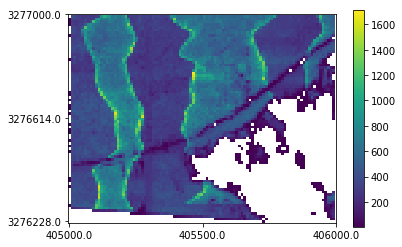

In [14]:
# Plot the count raster
my_rasters['raster']['z']['count'].plot()

We can easily iterate over `my_rasters` using typical `pandas` methods in conjunction with a `lambda` function. Upon each iteration, a `Raster` object is fed into the `lambda` function. We can use any attributes and methods from the `Raster` class that we would like. This allows for great flexibility!

Let's print out the number of rows and columns of each raster as an exercise.

In [19]:
my_rasters['raster'].apply(lambda raster_obj: raster_obj.array.shape)

dim        metric     
z          count          (77, 99)
           mean           (77, 99)
           crazy_index    (77, 99)
intensity  max            (77, 99)
Name: raster, dtype: object